##Optimization by Annealing

In [ ]:
# @title
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:

  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install dwave-ocean-sdk

In [ ]:
# @title
!pip install dwave-neal

In [ ]:
# @title
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

## Setting up the Problem class

In [ ]:
np.set_printoptions(threshold=np.inf)
class Problem:
    def __init__(self, M, N, lam, d, in_angles, out_angles, constraints=None):
        self.M = M
        self.N = N
        self.lam = lam
        self.d = d
        self.theta_in = in_angles[0]
        self.phi_in = in_angles[1]
        self.theta_out = out_angles[0]
        self.phi_out = out_angles[1]
        self.k = 2 * np.pi / lam
        self.Q = None  # will be computed when needed
        self.constraints = constraints

    def phase(self, m, n, theta_out, phi_out):
        part1 = -m * np.sin(theta_out) * np.cos(phi_out)
        part2 = -n * np.sin(theta_out) * np.sin(phi_out)
        part3 = m * np.sin(self.theta_in) * np.cos(self.phi_in)
        part4 = n * np.sin(self.theta_in) * np.sin(self.phi_in)
        return self.k * self.d * (part1 + part2 + part3 + part4)

    def compute_Q(self, theta_out = None, theta_in = None):

      if theta_out is None:
        theta_out = self.theta_out
      if theta_in is not None:
        theta_in = self.theta_in

      Q = np.zeros((self.M * self.N, self.M * self.N))
      for row in range(self.M * self.N):
          m1, n1 = divmod(row, self.M)
          for col in range(row):
              m2, n2 = divmod(col, self.M)
              phase_diff = self.phase(m1, n1, theta_out, phi_out) - self.phase(m2, n2, theta_out, phi_out)
              Q[row, col] = np.cos(phase_diff)
          # Q[row, row] = 0
      self.Q = Q

      return Q

    def array_factor(self,  w_arr, Q = None):
      if Q is None:
        if self.Q is None:
            self.compute_Q()
        Q = self.Q
      arr_fac = (1 / (self.M * self.N) ** 2) * (1*M*N + w_arr.T @ Q @ w_arr)
      return arr_fac[0,0]


    def check_constraints(self, w_arr):
        if self.constraints is None:
            return "No constraints"

        checks = []
        for constraint in self.constraints:
          theta_o = constraint[0]
          phi_o = constraint[1]
          threshold = constraint[2]

          Q_i = self.compute_Q(theta_o, phi_o)
          arr_fac_i = self.array_factor(w_arr, Q = Q_i)

          if arr_fac_i <= threshold:
            checks.append(True)
          else:
            checks.append(False)

        return checks


    def sort_with_partner(self, arr1, arr2):
      if len(arr1) != len(arr2):
          raise ValueError("Both arrays must be of the same length.")

      n = len(arr1)
      for i in range(n):
          min_index = i
          for j in range(i + 1, n):
              if arr1[j] < arr1[min_index]:
                  min_index = j
          # Swap in both arrays
          arr1[i], arr1[min_index] = arr1[min_index], arr1[i]
          arr2[i], arr2[min_index] = arr2[min_index], arr2[i]

      return arr1, arr2

    def ssn_soln(self):
      phase_list = np.zeros((self.M * self.N, 1))
      w_arr = np.zeros((self.M * self.N, 1))

      for i in range(self.M * self.N):
        m,n = divmod(i, self.M)
        phase_list[i] = (self.phase(m, n, self.theta_out, self.phi_out) % (2*np.pi))

      indices = list(range(self.M * self.N))
      phase_list_sorted, indices_sorted = self.sort_with_partner(phase_list, indices)

      w_arr_max = 0
      af_max = 0

      for i in range(self.M * self.N):
        delta_i = phase_list[i]
        indices_unsort = list(indices_sorted)
        if delta_i < np.pi:
          delta_i_lim = delta_i + np.pi
          for j in range(self.M * self.N):
            if delta_i <= phase_list[j] < delta_i_lim:
              w_arr[j] = +1
            else:
              w_arr[j] = -1

        else:
          delta_i_lim = delta_i - np.pi
          for j in range(self.M * self.N):
            if delta_i_lim < phase_list[j] < delta_i:
              w_arr[j] = -1
            else:
              w_arr[j] = +1

        indices_sort, w_arr_sort = self.sort_with_partner(indices_unsort, w_arr)
        af_cur = self.array_factor(w_arr_sort)
        if af_cur > af_max:
          af_max = af_cur
          w_arr_max = np.array(w_arr_sort)
      return af_max,w_arr_max



def cost(x,Q):
    return x.T @ Q @ x





Initializing the QUBO problem with parameters

In [ ]:
M = 4
N = 5
lam = 1e-3
d = lam / 1
theta_in = np.pi / 4
phi_in = np.pi / 3
theta_out = np.pi / 3
phi_out = np.pi / 4

## constrain parameters
theta_in2 = np.pi / 3
phi_in2 = np.pi / 5
theta_out2 = np.pi / 9
phi_out2 = np.pi / 5

K = 5

prob = Problem(M, N, lam, d, in_angles=(theta_in, phi_in), out_angles=(theta_out, phi_out), constraints=None)

prob2 = Problem(M,N,lam,d,in_angles=(theta_in2,phi_in2),out_angles=(theta_out2,phi_out2),constraints=None)

w_arr = np.ones((M * N, 1), dtype=float)

Q = prob.compute_Q()
Q2 = -5*prob2.compute_Q()

Q_input1 = (Q + Q.T + Q2 + Q2.T)

# # TRANSFORMING TO (0,1)

cQ = np.sum(Q_input1)

prod = np.ones((1,M*N)) @ Q_input1
q = np.zeros_like(Q_input1)

for i in range(M*N):
    q[i][i] = prod[0][i]

Q_input = 4*Q_input1 - 4*q

print(Q_input)


af_max, w_array_max = prob.ssn_soln()
print(af_max)
print(w_array_max)

print(cost(w_array_max, Q_input1))

[[-31.53856591   6.15623616  23.53506456  -2.36845743  19.11157954
    2.78587257 -20.20311403   1.07956137 -21.35238698 -11.94594952
   15.12008947  -0.12242521  14.92377541  13.06391063 -16.27418155
   -8.08833122  -6.29360696 -12.10434683  17.54927905  16.96599687]
 [  6.15623616 -37.86448338   6.15623616  23.53506456  -7.39761504
   19.11157954   2.78587257 -20.20311403   7.74190207 -21.35238698
  -11.94594952  15.12008947 -14.81534753  14.92377541  13.06391063
  -16.27418155  22.10708618  -6.29360696 -12.10434683  17.54927905]
 [ 23.53506456   6.15623616 -34.44975161   6.15623616 -18.0073136
   -7.39761504  19.11157954   2.78587257  10.87492371   7.74190207
  -21.35238698 -11.94594952 -10.26275508 -14.81534753  14.92377541
   13.06391063  10.17248614  22.10708618  -6.29360696 -12.10434683]
 [ -2.36845743  23.53506456   6.15623616 -28.86013096  10.78958255
  -18.0073136   -7.39761504  19.11157954 -18.89491879  10.87492371
    7.74190207 -21.35238698  18.49472142 -10.26275508 -14.81

---
###Brute Force algorithm to solve the problem

In [ ]:
# BRUTE FORCE

from itertools import product
  # total length = M * N

cost_optimal = 0
cur_cost =0
for x in product([-1, 1], repeat=M * N):
    # print(np.array(x))
    cur_cost = cost(np.array(x),Q+Q.T)
    if(cur_cost>cost_optimal):
        cost_optimal = cur_cost
        w_array_optimal = x

print(cost_optimal)
print(w_array_optimal)
print(w_array_max.T)
print(cost(w_array_max,Q_input1))




186.628251605718
(-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1)
[[-1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
  -1. -1.]]
[[209.47139256]]


### Plotting functions for Annealer

In [ ]:
#This is the code from the lecture notebooks to create the graphs of energy levels obtained, we use this to get a better understanding of the probabilities and energies
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    # print("minimum energy:", min(energies))


def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    # print("minimum energy:", min(energies))

### Defining quadratic model to input to D-Wave Annealers  

In [ ]:
#dimod package converts qubo model directly to ising models readable by annealers
model = dimod.BinaryQuadraticModel.from_qubo(-Q_input)


We can check the functioning of the model in Simulated Annealing before using the DWave QPU

In [ ]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model, num_reads=100,num_sweeps=100000,num_sweeps_per_beta = 1)


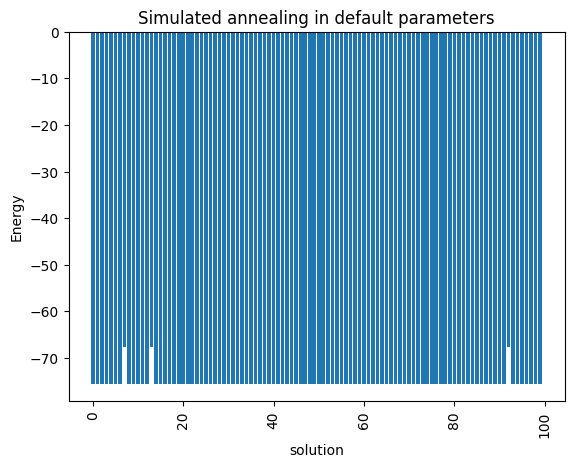

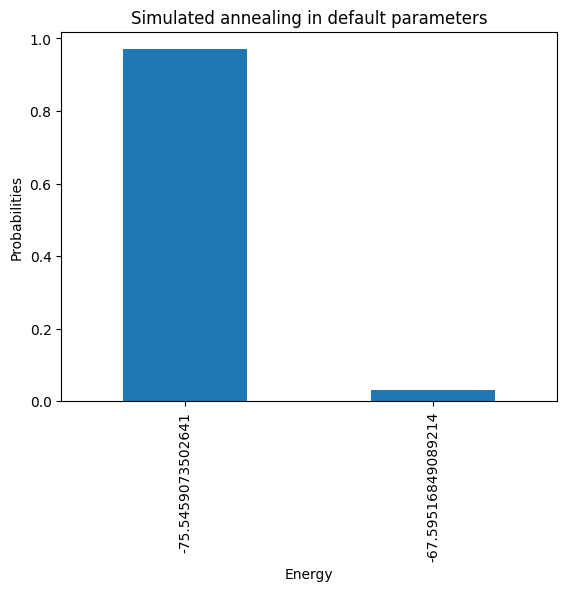

{'beta_range': [np.float64(0.030701976246052008), np.float64(2.7270285848772988e+16)], 'beta_schedule_type': 'geometric', 'timing': {'preprocessing_ns': 4667715, 'sampling_ns': 497588174, 'postprocessing_ns': 372521}}


In [ ]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')
print(simAnnSamples.info)

In [ ]:
sample = simAnnSamples.first.sample
sim_arr = np.array([sample[i] for i in sorted(sample)])
sim_arr = sim_arr*2 - np.ones_like(sim_arr)
print(sim_arr)
# print(w_array_optimal)
print(cost(sim_arr,Q_input1),cost(np.array(w_array_optimal),Q_input1))

[ 1  1  1 -1 -1 -1 -1 -1 -1  1  1  1]
63.754522777081405 63.754522777081405


Simulated annealing is slow for large problems.
---
## Now let's solve this using Quantum Annealing!







In [ ]:
# Let's setup the D-Wave connection
if IN_COLAB:
    !dwave setup

NameError: name 'IN_COLAB' is not defined

In [ ]:
!dwave ping

In [ ]:
import dwave_networkx as dnx
from dwave.system import (DWaveSampler, EmbeddingComposite,
                          FixedEmbeddingComposite)
from pprint import pprint

In [ ]:
# Graph corresponding to D-Wave 2000Q
qpu = DWaveSampler()
qpu_edges = qpu.edgelist
qpu_nodes = qpu.nodelist
pprint(dir(qpu))
if qpu.solver.id == "DW_2000Q_6":
    print(qpu.solver.id)
    X = dnx.chimera_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_chimera(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))
elif qpu.solver.id == "Advantage_system1.1":
    print(qpu.solver.id)
    X = dnx.pegasus_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_pegasus(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))
print(len(qpu_nodes),len(qpu_edges))

In [ ]:
print(qpu.properties["annealing_time_range"])
qpu.properties["default_annealing_time"]

### Annealing with the D-Wave QPU and comparing plots:

In [ ]:
DWavesampler = EmbeddingComposite(DWaveSampler())

initial = np.ones(M*N)
# Define a reverse annealing schedule
# (time in μs, anneal fraction s)
schedule = [
    (0.0, 1.0),         # Start at classical
    (5.0, 0.45),        # Reverse to s=0.45
    (35.0, 0.45),       # Pause for 30 μs
    (40.0, 1.0)         # Anneal forward
]

DWaveSamples = DWavesampler.sample(bqm=model, initial_state = {i: initial[i] for i in range(len(initial))},
                                   anneal_schedule = schedule, num_reads=100, return_embedding=True, reinitialize_state=True)

In [ ]:
print(DWaveSamples.info)

{'timing': {'qpu_sampling_time': 15126.0, 'qpu_anneal_time_per_sample': 30.0, 'qpu_readout_time_per_sample': 100.68, 'qpu_access_time': 30885.96, 'qpu_access_overhead_time': 1218.04, 'qpu_programming_time': 15759.96, 'qpu_delay_time_per_sample': 20.58, 'post_processing_overhead_time': 90.0, 'total_post_processing_time': 90.0}, 'problem_id': '41dc1add-f286-4b6a-a6aa-a699224ad453', 'embedding_context': {'embedding': {1: (3799, 3801, 3800), 0: (4100, 1159, 1160), 2: (964, 1100, 3846, 3845), 3: (4041, 1266, 1264, 1265), 4: (1249, 3891, 1250), 5: (1339, 3830, 3831), 6: (1294, 1295, 3965, 3966), 7: (3951, 1069, 3950, 1070), 8: (1116, 1114, 1115), 9: (1324, 1280, 3815, 3816), 10: (4071, 1189, 1190), 11: (1085, 979, 3861, 3860), 12: (1054, 4011, 4010, 1055), 13: (3771, 3769, 1099, 3770), 14: (3906, 3905, 994, 3904), 15: (1220, 1219, 3935), 16: (1024, 1025, 4026, 4025), 17: (3876, 1234, 1235), 18: (4085, 1174, 3996, 1175), 19: (1039, 3786, 3785), 20: (1084, 3754, 3756, 3755), 21: (3981, 1009, 1

In [ ]:
embedding = DWaveSamples.info['embedding_context']['embedding']
if qpu.solver.id == "DW_2000Q_6":
  dnx.draw_chimera_embedding(X, embedding, node_size=2)
elif qpu.solver.id == "Advantage_system1.1":
  dnx.draw_pegasus_embedding(X, embedding, node_size=2)

minimum energy: -291.5993683103575


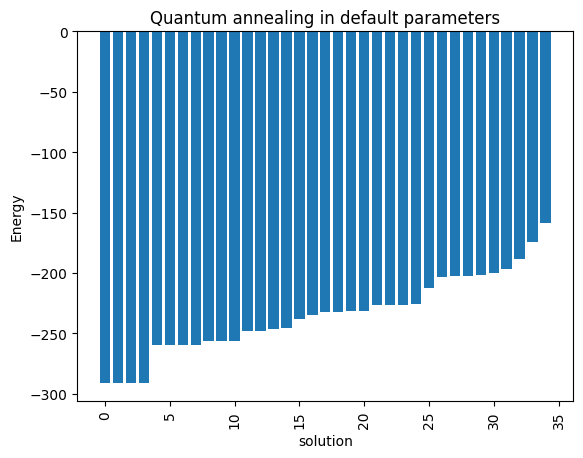

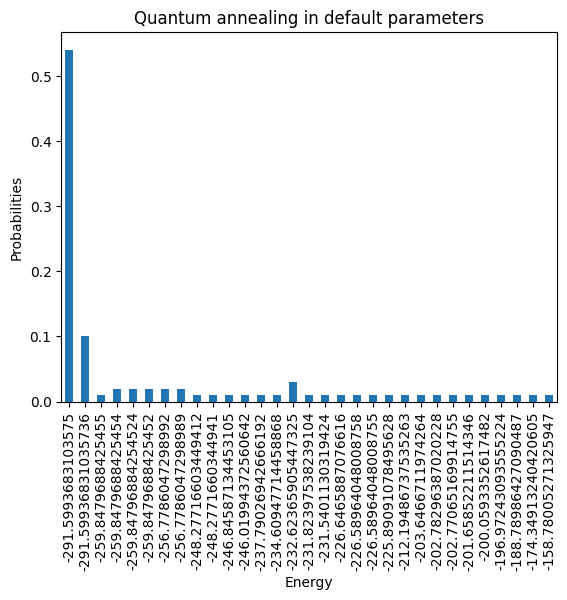

minimum energy: -291.5993683103575


In [ ]:
plot_enumerate(DWaveSamples, title='Quantum annealing in default parameters')
plot_energies(DWaveSamples, title='Quantum annealing in default parameters')

In [ ]:
dsample = DWaveSamples.first.sample
arr = np.array([dsample[i] for i in sorted(dsample)])
arr = np.ones_like(arr) - arr*2
print(arr)
print(sim_arr)
print(cost(sim_arr,Q_input1),cost(arr,Q_input1))
# print(w_array_optimal)
# print(cost(arr,Q_input1),cost(np.array(w_array_optimal),Q_input1))

[-1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1  1  1  1  1 -1
  1  1  1 -1 -1 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1  1 -1  1 -1  1  1
  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1 -1
  1  1  1  1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1
  1  1  1  1]
5546.46204629681 799.9973783666283
